# Monte Carlo parameter resampling simulations using the `Optimizer` class 

The `prms_python` module's `Optimizer` class `monte_carlo` method allows for methods of step-wise parameter optimization of PRMS consisting of arbitray user defined steps, e.g.:
1. Solar radiation
2. Potential evapotranspiration
3. Streamflow (surface runoff, interflow, groundwater flow)

The monte carlo resampling routine is conducted on a set of PRMS parameters that are pseudo-randomly modified. In this example we show how to run the monte carlo simulation by modification on the degree day solar radiation parameters in PRMS, 

* `dday_slope` 
* `dday_intcp` 

These two parameters are used in a modified degree-day model `ddsolrad` a PRMS module that relates daily maximum temperature to the ratio of actual to potential daily solar radiation which is later used to estimate daily solar radiation. When using PRMS's ddsolrad module `dday_slope`, and `dday_intcp` are required for each month. The initial estimation of these parameters should be calculated using historical air temperature and solar radiation measurements if available as described in the [PRMS manual](http://pubs.usgs.gov/tm/6b7/). It is important to have the original parameter estimation as accurate as possible to reduce the number of monte carlo simulations required to get improved results. The pseudo-random sampling method that the `Optimizer.monte_carlo` method uses works by generating new parameter sets by random samping around the monthly parameter values that exist in the initial parameter set (see below). Currently, two resampling methods exist: *normal* and *uniform*, explained below. 

In [2]:
from prms_python import Data, Optimizer, Parameters, util
from prms_python.optimizer import resample_param as resample
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')
%matplotlib inline

## Example of 50 pseudo-random parameter sets created using *uniform* resmapling of the `Optimizer.monte_carlo` method

This illustration shows the distribution of new parameter values for each monthly parameter value for the degree day slope parameter. The default resampling method is *uniform* which results in a new parameter set that is resampled from a uniform distribution with the parameter range set for the uniform distribution parameters $U(a,b)$ where $a$ is the minimum allowable parameter value and $b$ is the maximum allowable parameter value as set by the user in the `optimizer.py` file, specifically they are defined in a dictionary which is an attribute of the `Optimizer` class: `Optimizer.param_ranges`. If the user does not input the parameter they want to resample along with a minimum and maximum value in `Optimizer.param_ranges` the `monte_carlo` method will not run. The `param_ranges` dictionary consists of PRMS parameter names as keys and a tuple containing the minimum and maximum parameter value respectively. Be sure to never exceed PRMS's allowable range however it may be useful to limit the range in some cases. Here is an example of a potential `param_ranges` dictionary in `optimizer.py` that is used for this example.

```python
class Optimizer: 

    param_ranges = {'dday_intcp': (-60.0, 10.0), 'dday_slope': (0.2, 0.9),\     
                    'jh_coef': (0.005, 0.06), 'pt_alpha': (1.0, 2.0), \         
                    'potet_coef_hru_mo': (1.0, 1.6), 'tmax_index': \            
                    (-10.0, 110.0)\                                             
                   }
```

The *uniform* resample method can be used when the initial estimation of the parameter of interest is highly uncertain, when using *uniform* resampling it will be computationally expensive to improve parameter accuracy and it is recommended to use on perhaps one parameter at a time, as opposed to a set of parameters as shown in this example. 

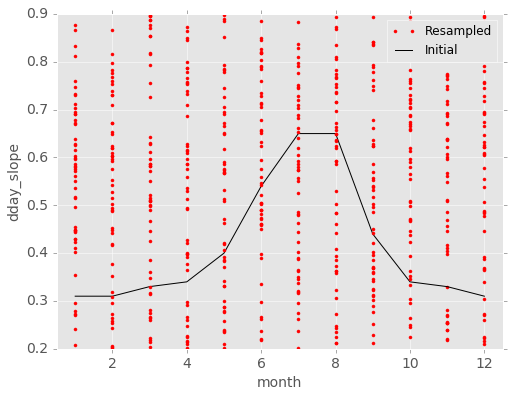

In [3]:
params = Parameters('../test/data/models/lbcd/parameters')

plt.figure(figsize=(8,6))
for i in range(50):
    plt.plot(np.arange(1,13), resample(params, 'dday_slope'), 'r.')
    if i == 0:
        plt.plot(np.arange(1,13), resample(params, 'dday_slope'), 'r.', label='Resampled')
        plt.plot(np.arange(1,13), params['dday_slope'], 'k', label = 'Initial')
plt.xlim(0.5,12.5)
plt.xlabel('month', fontsize=14)
plt.ylabel('dday_slope',fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend()

As you can see, the random *uniform* resampling of the parameter results in a uniform ditribution for each value regardless of the initial parameter values. 

## Random parameter resamples created using *normal* resampling 

The *normal* resampling method is computed taking a normal random variable (RV) with mean set as the initial parameter value(s) mean multiplied by the `mu_factor` keyword argument. In the case of higer dimension or parameters of length > 366 such as spatial parameters, the *normal* method has a different functionality. Specifically, as opposed to simply replacing the parameter values with a normal RV, the initial parameter values are added to a normal RV therein to keep the temporal or spatial structure of the initial parameter set. The user has control over the normal RV's variance by using the `noise_factor` keyword argument which scales the variance of the normal RV:

\begin{align}
P_{new} & = N(\mu_{P_{init}} \times mu\_factor, ~\sigma^2)  \\
\sigma^2 & = (P_{max} - P_{min} ) \times noise\_factor, 
\end{align}

or in case of higher length (> 366) parameters: 

\begin{align}
P_{new} & = P_{init} \times mu\_factor + N(0, ~\sigma^2)  \\
\sigma^2 & = (P_{max} - P_{min} ) \times noise\_factor, 
\end{align}

where $P_{new}$ is the resampled parameter value, $P_{init}$ is the initial parameter value, $P_{max}$ and $P_{min}$ are the maximum and minimum allowable parameter values respectively. Again the user must enter the parameter name along with $P_{max}$ and $P_{min}$ in `Optimizer.param_ranges` before being able to resample it.

The plot below shows the resulting resamples values of the tmax_index monthly parameter where the mean was halfed (`mu_factor`=0.5) and `noise_factor`=0.2. Note that because this parameter is of length $12 \le 366$, each value is resampled individually as in the first equation above. 

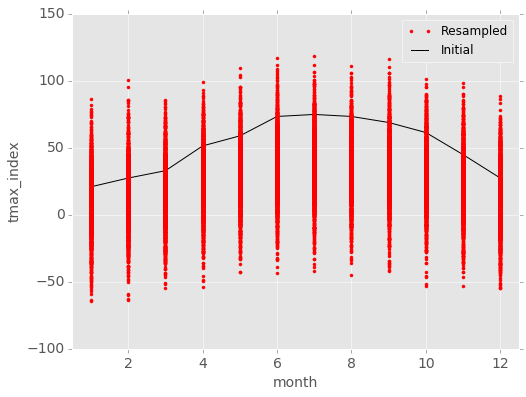

In [4]:
param = 'tmax_index'
plt.figure(figsize=(8,6))
for i in range(1500):
    plt.plot(np.arange(1,13), resample(params, param, how='normal', mu_factor=.5, noise_factor=0.2), 'r.')
    if i == 0:
        plt.plot(np.arange(1,13), resample(params, param, how='normal', noise_factor=0.2), 'r.', label='Resampled')
        plt.plot(np.arange(1,13), params[param], 'k', label = 'Initial')
plt.xlim(0.5,12.5)
plt.xlabel('month', fontsize=14)
plt.ylabel(param,fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend()

When using the *normal* resampling option it may be important to have a good initial estimation of the parameters you are trying to optimize as shown above. However the method can also be used to systematically shift parameter means to look at the resulting uncertainty in model outputs by changing the mean by a specified fraction and not necesarrily changing the variance.

## Resampling rules based on parameter dimension and length

* If the parameter dimension is 1 and the parameter length $\le 366$: resample each value
* If the parameter dimension is 1 and the parameter length $> 366$ resample all values at once
* If the parameter dimension is 2, specifically *nhru_nmonths*, then resample each monthly parameter set all at once

These rules were chosen for computational efficiency and practicality by avoiding individual resampling of spatial parameters. We would however like to add functionality for spatial resampling based on PRMS subbasins or other parameters in the future.  

## Example uses of *normal* resampling on spatial variables
To illustrate how the resampler handles higher length parameters such as the spatial parameter soil_moist_max, we show two plots below. In the first subplot we adjust the mean by a factor of 2 with little added variance, and in the second we do not adjust the mean but only add noise using a normal RV with mean 0. 

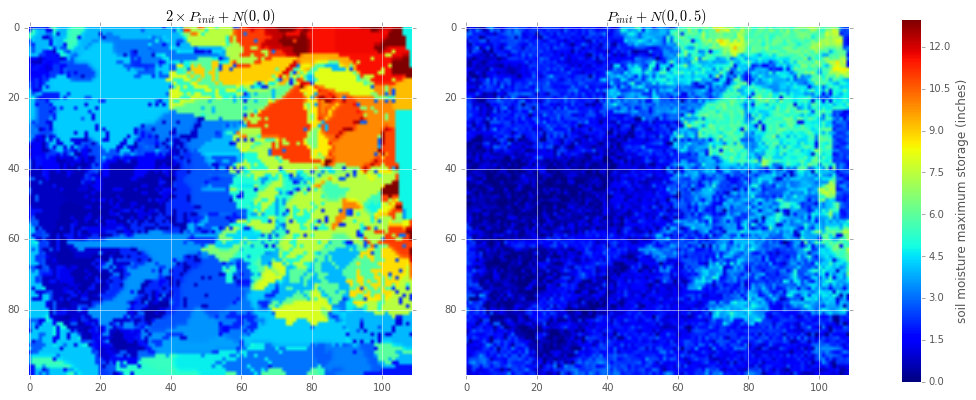

In [5]:
param = 'soil_moist_max'
fig, (ax1,ax2,cax) = plt.subplots(ncols=3, figsize=(16,6.5), gridspec_kw={"width_ratios":[1,1, 0.05]})

ax1.imshow(resample(params, param, how='normal', mu_factor=2, noise_factor=0.00000001).reshape(99,109)\
           ,vmin=0, vmax=13)
ax1.set_title(r'$2 \times P_{init} + N(0, 0) $')

im=ax2.imshow(resample(params, param, how='normal', mu_factor=1, noise_factor=0.05).reshape(99,109)\
              ,vmin=0, vmax=13)
ax2.set_title(r'$ P_{init} + N(0, 0.5) $') #stdev = noise_factor X param_range = 0.5
fig.colorbar(im,cax=cax, label='soil moisture maximum storage (inches)')

# A simple workflow using the `Optimizer` class and the `monte_carlo` method on two solar radiation parameters 

In [6]:
# set file paths for input files and output directory as well as measured solar radiation csv
params = Parameters('../test/data/models/lbcd/parameters')
data = Data('../test/data/models/lbcd/data')
control = '../test/data/models/lbcd/control'
work_directory = '../test/results/'
# create an Optimizer instance with the paths, be sure to always give it a title (required)
optr = Optimizer(params, data, control, work_directory, title='testing_srad')

You have no statvar.dat file in your model directory
Running PRMS on original data in ../test/data/models/lbcd for later comparison


## The measured data file 

The measured solar radiation file is needed for comparing the simulated results to itself to determine model accuracy, because it is not a required file for PRMS we explain it here as well. It is simply a csv file without a header, the first column should contain a date in the form YYYY-MM-DD and the second column contains the measured data. In this case the measured data we are calibrating on is solar radiation from a weather station located near a PRMS hydrologic response unit (HRU). 

Other date formats may work as well but were not tested, the function used to read the file is [Pandas.Series.from_csv](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.from_csv.html) with the `parse_dates=True` keyword argument which tries to parse the index (first column) as date-times. 

In [7]:
srad_hru = 2490
measrd = '../test/data/fake_measured_swrad_lbcd.csv'
# top 5 lines of a valid measured solar radiation file
with open(measrd) as fh:
    for i,line in enumerate(fh):
        print(line.strip())
        if i == 4: break

1937-10-01,447.752204422
1937-10-02,441.216580147
1937-10-03,410.682144625
1937-10-04,176.349945467
1937-10-05,126.152799887


In [8]:
# run the monte carlo simulations with normal resampling method for 4 simulations
stage = 'ddsolrad' # user defined calibration/optimization stage
output_variable = 'swrad_2490'
optr.monte_carlo(measrd, ['tmax_index','dday_intcp'], output_variable, n_sims=4, method='normal',\
                 noise_factor=0.1, stage=stage)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:3727: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


['../test/results/tmax_index_51.4479452114', '../test/results/tmax_index_50.4660898301', '../test/results/tmax_index_51.6971617025', '../test/results/tmax_index_54.9281475979']
--------------------------------------------------------------------------------
Output information sent to ../test/results/testing_srad_ddsolrad_opt.json



_**Side note**_, the `monte_carlo` method saves metadata to a [json file](http://json.org/) for each succeesful execution, basic information is printed to the console also, including the location of the json that was just created from the current optimization routine. Here is the contents of a Monte Carlo optimization simulation json that was initiated the same way as the one shown above:

```python
{
    "end_datetime": "2018-08-06T16:06:10.981373",
    "measured": "../test/data/fake_measured_swrad_lbcd.csv",
    "method": "Monte Carlo",
    "mu_factor": 1,
    "n_sims": 4,
    "noise_factor": 0.1,
    "nproc": 4,
    "optimization_description": null,
    "optimization_title": "testing_srad",
    "original_params": "../test/data/models/lbcd/parameters",
    "params_adjusted": [
        "tmax_index",
        "dday_intcp"
    ],
    "resample": "normal",
    "sim_dirs": [
        "../test/results/tmax_index_53.1266889019",
        "../test/results/tmax_index_54.8540785043",
        "../test/results/tmax_index_50.5818611757",
        "../test/results/tmax_index_47.2399851267"
    ],
    "stage": "ddsolrad",
    "start_datetime": "2018-08-06T16:05:18.901943",
    "statvar_name": "swrad_2490"
}
```

This information is useful for the user and the PRMS-Python framework, and json is a natural fit because the syntax of json is pretty much identical to the Python dictionary data structure. 

### output file naming system
Each PRMS simulation conducted under a `monte_carlo` optimization routine has its own unique directory such that the user can revisit the input and output of any simulation. Each simulation will follow the rules that are set from the initial control file given to the `Optimizer` instance. The name of each simulation is used for future referencing and has the following format 

```bash
[param_name]_[mean value of first param_name to 10 decimal points]
```
for example:

```bash
tmax_index_48.2399851267
```

If the user resamples more than one parameter at a time for a given parameter `Optimizer` instance the output directory names will use only the parameter name:mean of the first parameter given as input to the call of `monte_carlo`. You can see this above, the `monte_carlo` method was called with two parameter however only the first one *tmax_index* was used in the output directory names. Note, the JSON metadata file retains the entire list of modified parameters and the output directorys contain the actual resampled parameter sets for each simulation, therefore no information is lost if the user desires it for whatever purpose. The likelyhood of having the mean of any two or more resmapled parameters identical to 10 decimals is extremely small, therefore each name is more or less unique. Each JSON metadata file maps to the set of output (simulation) directories that it corresponded with, and there is never a case where a metadata (json) file name will be duplicated due to a built in renaming system. If there ever was a duplicated parameter set within a single `Optimizer.monte_carlo` simulation, the established simulation directory would simply be overwritten and both JSON files would point to the last overwritten Simulation directory. If this turns out to be an issue in testing we may switch to universal unique identifiers as Simulation directory names.

## Quick and basic visualizations of current optimization results
These plots are only useful for quick viewing of the current `Optimizer` instance outputs, i.e. not what have been executed in a seperate script even if previous `Optimizer` routines have been conducted on the same parameter set. For viewing accuracy of many different `Optimizer` routines conducted using the same user defined *stage* use the `OptimizationResult` class. 

### correlation between measured and simulated
* plots a one to one line and scatterplots of simulated versus measured for each monte carlo simulation result
* plots coefficient of determination $R^2$ for each simulation against the measured data

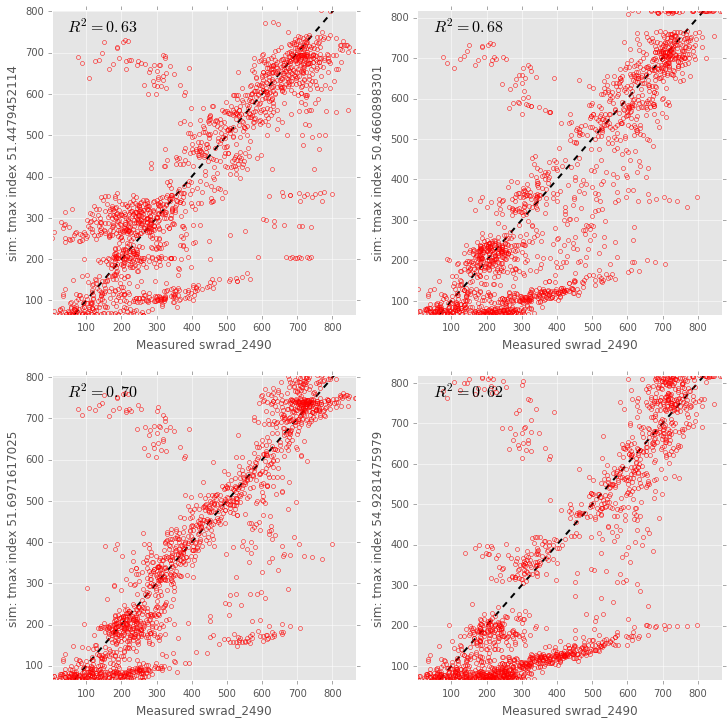

In [9]:
optr.plot_optimization(method='correlation')

### time series of daily measured, initially simulated and new simulated data (default method)

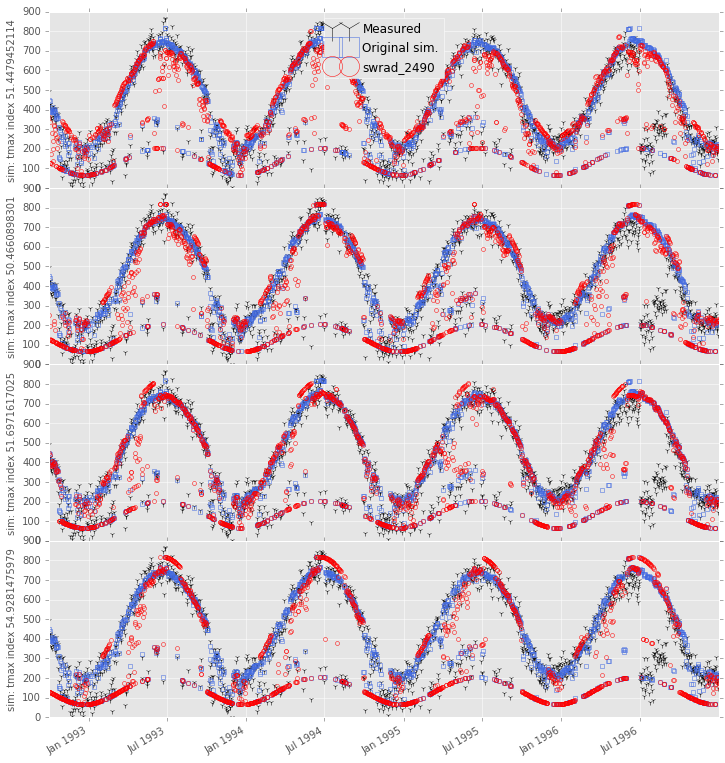

In [10]:
optr.plot_optimization()

### monthly means

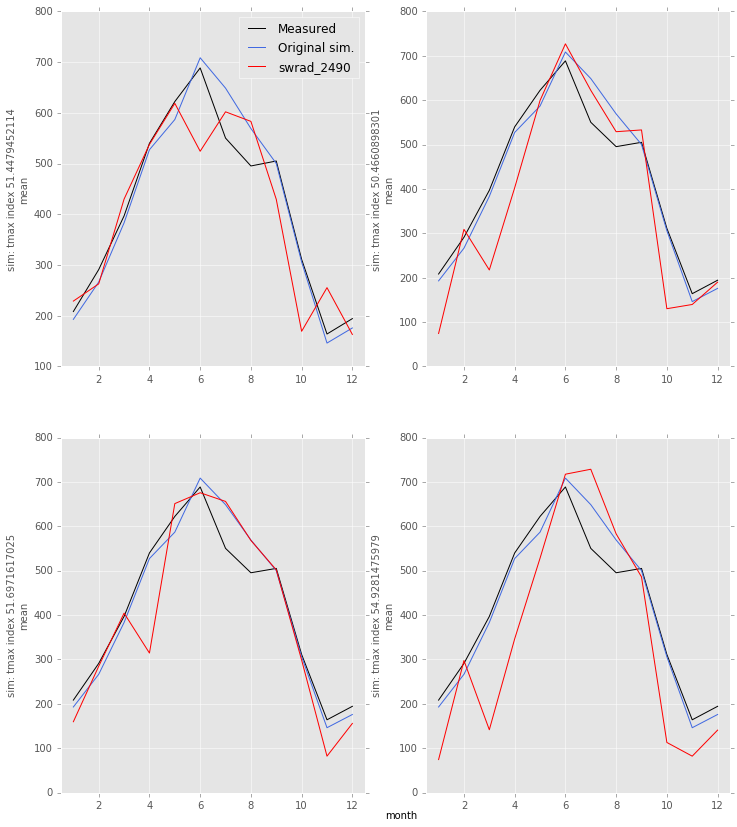

In [11]:
optr.plot_optimization(freq='monthly')

## Get figure object using keyword `return_fig` and save image to disk
### only plot measured and simulated data (not original simulation) 

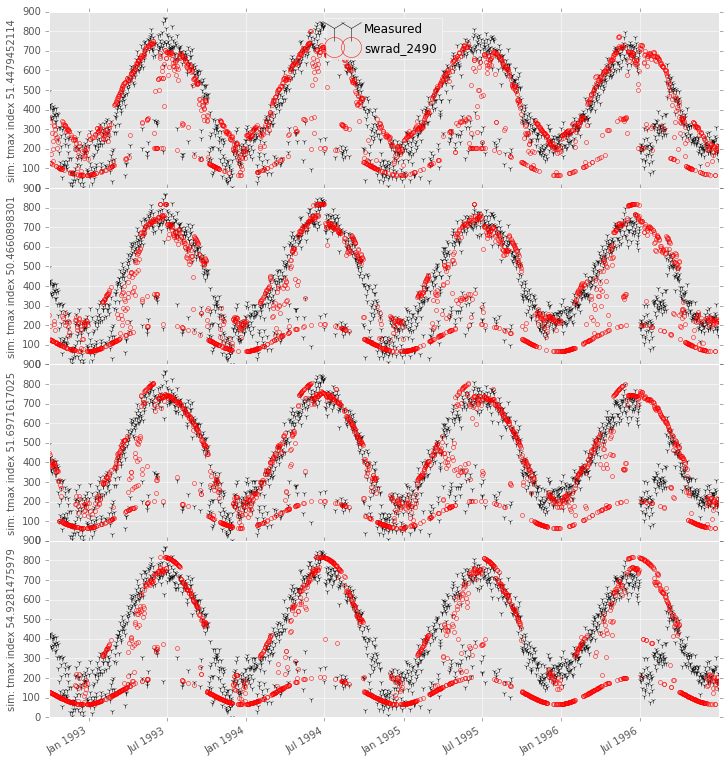

In [12]:
#you can change the plot_vars keyword option to show both measured and original simulated solar radiation
# or one or the other alongside the optimization simulations using: 'both', 'meas', or 'orig'
fig = optr.plot_optimization(freq='daily', plot_vars='meas', return_fig=True)

In [12]:
#easily save figure, in this case in eps format, matplotlib offers many other options
fig.savefig('MyOptimizationFig.eps', format='eps')

## Run more optimization simulations on the same `Optimizer` object and view results alongside any previous

Say we wanted to run two additional simulations using the default optimization method for solar radiation, instead of creating a new optimization instance we can simply call `swrad` method on the current object with new arguments. Results will be appended to the output containers in the `Optimizer` object. 

In [13]:
#same as before except we want to run two new simulations
optr.monte_carlo(measrd, ['tmax_index','dday_intcp'], \
                 output_variable, n_sims=2, method='normal', noise_factor=0.1, stage=stage)

['../test/results/tmax_index_60.9461936073', '../test/results/tmax_index_58.3766673754']
--------------------------------------------------------------------------------
Output information sent to ../test/results/testing_srad_ddsolrad_opt1.json



## View results including the two new simulations

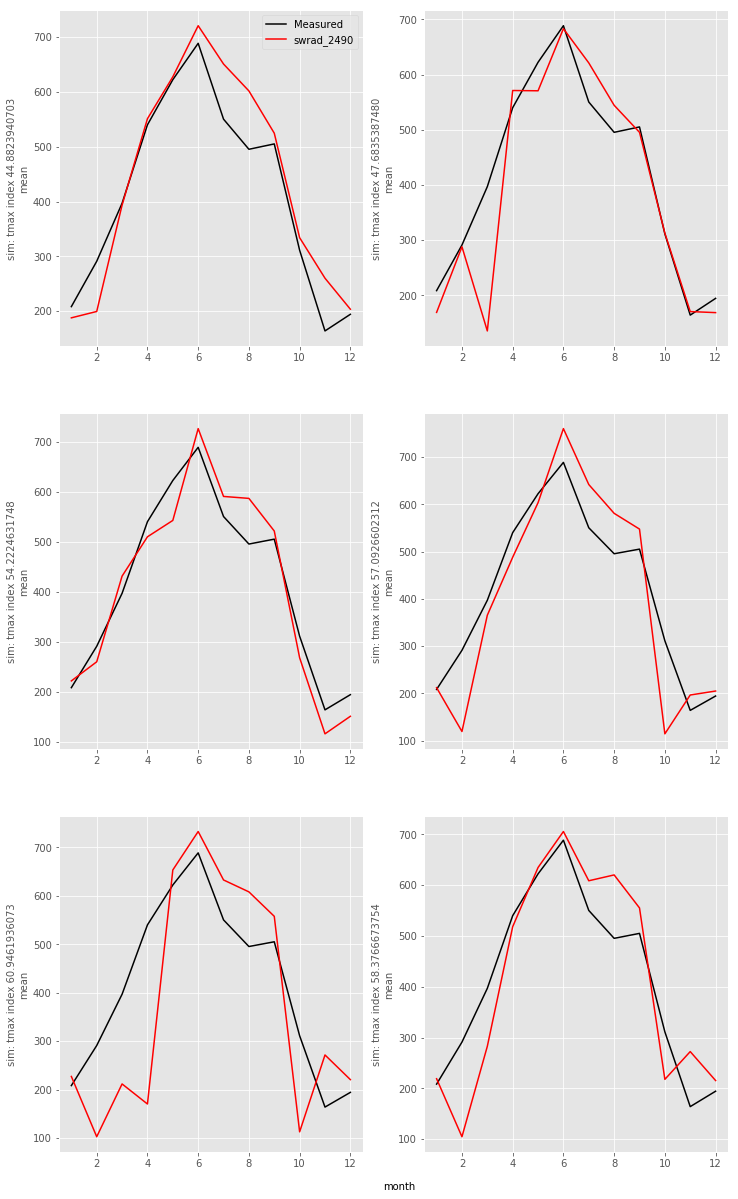

In [14]:
optr.plot_optimization(freq='monthly', plot_vars='meas', n_plots=6)